# Extracting Flooding Areas from NRT Sentinel-1 Satellite Imagery

In [1]:
from scripts.constants import create_scenes_df
import pandas as pd                 
import os
import dataretrieval.nwis as nwis  
import matplotlib.pyplot as plt
import subprocess                                                   # for multithreading
import multiprocessing                                              #  "     "      "
from concurrent.futures import ThreadPoolExecutor
from ipyleaflet import Map, basemaps, basemap_to_tiles 
from ipyleaflet import GeoData, LayersControl, ImageOverlay
import geopandas as gpd                                             # read geospatial data
import ipywidgets as widgets                                        # interactive display

In [2]:
# Set up a working environment

# get number of cores to use for Threadpool Execture
logical_cores = multiprocessing.cpu_count()
num_workers = int(logical_cores * 0.8)  # rounds down in case not a whole number

print(f'Number of threads to use: {num_workers}')

Number of threads to use: 8


## Review the water data

Use the [USGS Water Services Instantaneous API](https://waterservices.usgs.gov/test-tools/?service=iv&siteType=&statTypeCd=all&major-filters=sites&format=json&date-type=type-none&statReportType=daily&statYearType=calendar&missingData=off&siteStatus=all&siteNameMatchOperator=start) to retreive data for a USGS Gage in Frankfort, Kentucky. 

Dataretrieval Python Documentation:
    [https://doi-usgs.github.io/dataretrieval-python/index.html](https://doi-usgs.github.io/dataretrieval-python/index.html)  
    I will used the dataretrievel.nwis.get_iv

In [3]:
# set up variables for the instantaneous values (iv)
# query ~60 days of data
sites= '03287500'                      # site number for USGS Gage in Frankfort
start = '2025-01-15'                   # filter for the range of start date
end = '2025-03-15'                     # and end data
parameterCd = ["00060", "00065"]       # parameter codes for gage discharge in cubic feet/second
                                       # and height in feet                                       

In [4]:
# create a metalink link and datafram
water_df, water_md = nwis.get_iv(
    sites=sites,
    start=start,
    end=end,
    parameterCd=parameterCd,
    multi_index=True,
)
print(water_df.columns)
water_df.head(2)

Index(['site_no', '00060', '00060_cd', '00065', '00065_cd'], dtype='object')


,site_no,00060,00060_cd,00065,00065_cd
datetime,,,,,
2025-01-15 05:00:00+00:00,03287500,7490.0,P,9.17,P
2025-01-15 05:15:00+00:00,03287500,7490.0,P,9.17,P


#### Datframe cleaning
- drop columns
- rename columns
- reset index
- convert datatime to date

In [5]:
def clean_water_df(df):
    # Drop site_no and columns that end in cd
    cols_to_drop = ['site_no','00060_cd', '00065_cd']
    df = df.drop(columns=cols_to_drop, axis=1)

    # rename columns
    cols_to_rename = {'00060': 'discharge (cubic feet)', '00065': 'stream height (feet)'}
    df = df.rename(columns=cols_to_rename)

    # reset index so we can use datetime
    df = df.reset_index()           
    df['date'] = pd.to_datetime(df['datetime'], errors='coerce').dt.date
    df

    new_df = df.iloc[:, [3, 2, 1]]
    new_df

    return new_df

In [6]:
# call function to clean
clean_water_df = clean_water_df(water_df)
print(clean_water_df.columns)
clean_water_df.tail(2)

Index(['date', 'stream height (feet)', 'discharge (cubic feet)'], dtype='object')


,date,stream height (feet),discharge (cubic feet)
5754,2025-03-16,11.26,18000.0
5755,2025-03-16,11.29,18200.0


In [7]:
print(list(clean_water_df.columns))         # print list of fields
print(f'\n{clean_water_df.dtypes}')         # check dtype
clean_water_df.head(1)                      # See actual data

['date', 'stream height (feet)', 'discharge (cubic feet)']

date                       object
stream height (feet)      float64
discharge (cubic feet)    float64
dtype: object


,date,stream height (feet),discharge (cubic feet)
0,2025-01-15,9.17,7490.0


#### Group the data by date and return max value for stream height and discharge for that day. 

In [8]:
clean_water_df_groupby = clean_water_df.groupby('date', as_index=False).agg({
    'stream height (feet)': 'max',
    'discharge (cubic feet)': 'max'
})
print(f'The new dataframe has {clean_water_df_groupby.shape[1]} columns\nand {clean_water_df_groupby.shape[0]} rows.')
clean_water_df_groupby.head(3)

The new dataframe has 3 columns
and 61 rows.


,date,stream height (feet),discharge (cubic feet)
0,2025-01-15,9.17,7490.0
1,2025-01-16,9.09,7180.0
2,2025-01-17,8.92,6540.0


#### Plot the data

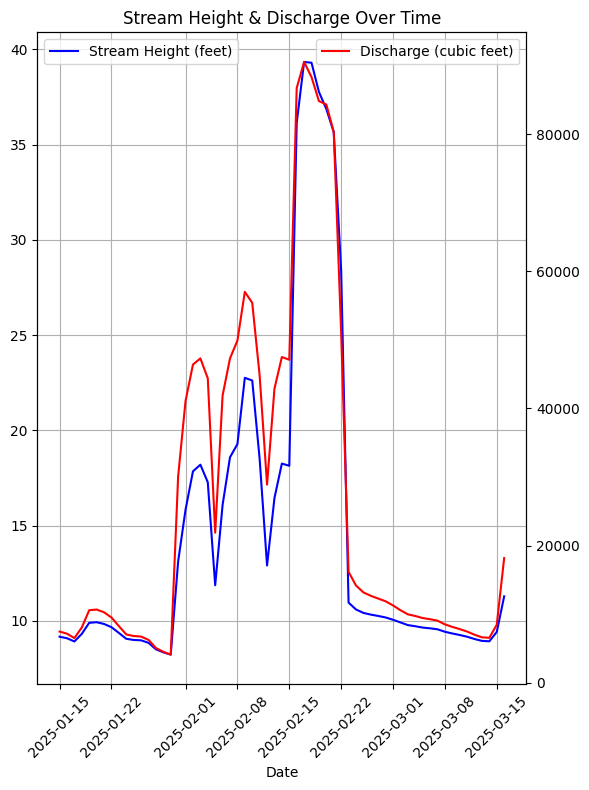

In [9]:
gage_data = clean_water_df_groupby

# have the plot read date as datetime, otherwise it looks messy
gage_data['date'] = pd.to_datetime(gage_data['date'])

# set x and y values
x = gage_data['date']
y1 = gage_data['stream height (feet)']
y2 = gage_data['discharge (cubic feet)']

fig,ax = plt.subplots(figsize=(6,8))

ax.plot(x, y1, color = 'b', label='Stream Height (feet)')
ax2 = ax.twinx()
ax2.plot(x,y2, color='r', label='Discharge (cubic feet)')
ax.set_xlabel('Date')
ax.set_title('Stream Height & Discharge Over Time')

# Add legends
ax.legend(loc='upper left')  
ax2.legend(loc='upper right')

# rotate the x-axis labels to fit more
ax.tick_params(axis='x', rotation=45)  

ax.grid(True)

# plot
fig.tight_layout()
plt.show()

## Download Imagery

1. Create a function that downloads two scenes and processing elevation data.
2. Create a function that setups up a dataframe
3. Create dataframe and download data

In [10]:
def box_download(df):
    out_folder = "data"
    download_zip = os.path.join(out_folder, 'file.zip')
    for index, row in df.iterrows():
        link = row['link']
        unzipped_folder = row['scene_folder']
        unzip_path = os.path.join(out_folder, unzipped_folder)

        cmd = f"curl -L -o {download_zip} {link} && unzip {download_zip} -d {out_folder}"
        
        if not os.path.exists(unzip_path):
            subprocess.run(cmd, shell=True, check=True)
            # delete downloaded zip file.
            os.remove(download_zip)
        else:
            print(f'Extracted Files already exist for "{unzipped_folder}"')

In [11]:
def create_scenes_df():
    
    """
       SAR Data:
        These files were obtained using the ASF Vertex Data Search.
        They were submitted for Radio Terrain Correctiom.
        radiometry: gamma0
        scale: decibel
        pixel spacing: 10m
       
        Digital Elevation Model processing:
         The dem processing folder contains the DEM used for radio-
         terrain correction and derivative produces used to create 
         a HAND and water mask.
    """

    box_data = {
        'zipfile': ['S1A_IW_20250205T233956_DVP_RTC10_G_gdufem_246A.zip',
                    'S1A_IW_20250217T233955_DVP_RTC10_G_gdufem_E701.zip',
                    'dem_processing.zip'],
        'link': ['https://ky.box.com/shared/static/xwhzpb6entefdhsi8jfhgii1f4ehh6x6.zip', 
                'https://ky.box.com/shared/static/81wf3fabzhzsux29nhe4ojdaq0qtwp89.zip',
                'https://ky.box.com/shared/static/rz15mqljj1m0tcejhu647haey6sfrfkf.zip']
            }
    scenes_df = pd.DataFrame(data=box_data)

    # calculate some fields
    scenes_df['scene_folder'] = scenes_df['zipfile'].apply(lambda x: os.path.splitext(x)[0])
    if not scenes_df['scene_folder'].eq('dem_processing.zip').any():
        scenes_df['input_dem'] = scenes_df['scene_folder'] + '_dem.tif'
        scenes_df['rgb'] = scenes_df['scene_folder'] +  '_rgb.png'
        scenes_df['vv'] = scenes_df['scene_folder'] + '_vv.tif'
        scenes_df['vh'] = scenes_df['scene_folder'] + '_vh.tif'
        scenes_df['shapefile'] = scenes_df['scene_folder'] + '_shape.shp'
    else:
        print("dem processing is not a scene")
    return scenes_df

In [12]:
scenes_df = create_scenes_df()
scenes_df

,zipfile,link,scene_folder,input_dem,rgb,vv,vh,shapefile
0,S1A_IW_20250205T233956_DVP_RTC10_G_gdufem_246A...,https://ky.box.com/shared/static/xwhzpb6entefd...,S1A_IW_20250205T233956_DVP_RTC10_G_gdufem_246A,S1A_IW_20250205T233956_DVP_RTC10_G_gdufem_246A...,S1A_IW_20250205T233956_DVP_RTC10_G_gdufem_246A...,S1A_IW_20250205T233956_DVP_RTC10_G_gdufem_246A...,S1A_IW_20250205T233956_DVP_RTC10_G_gdufem_246A...,S1A_IW_20250205T233956_DVP_RTC10_G_gdufem_246A...
1,S1A_IW_20250217T233955_DVP_RTC10_G_gdufem_E701...,https://ky.box.com/shared/static/81wf3fabzhzsu...,S1A_IW_20250217T233955_DVP_RTC10_G_gdufem_E701,S1A_IW_20250217T233955_DVP_RTC10_G_gdufem_E701...,S1A_IW_20250217T233955_DVP_RTC10_G_gdufem_E701...,S1A_IW_20250217T233955_DVP_RTC10_G_gdufem_E701...,S1A_IW_20250217T233955_DVP_RTC10_G_gdufem_E701...,S1A_IW_20250217T233955_DVP_RTC10_G_gdufem_E701...
2,dem_processing.zip,https://ky.box.com/shared/static/rz15mqljj1m0t...,dem_processing,dem_processing_dem.tif,dem_processing_rgb.png,dem_processing_vv.tif,dem_processing_vh.tif,dem_processing_shape.shp


I don't think using multiprocessing helps now that I'm using a subprocess, but it's not hurting it either.

Download could take several minutes, depending upon bandwidth.  Zipped up, the scenes are over 10gb in size each.  The dem products folder is ~2.5gb.

In [13]:
# download data from Box
box_download(scenes_df)

Extracted Files already exist for "S1A_IW_20250205T233956_DVP_RTC10_G_gdufem_246A"
Extracted Files already exist for "S1A_IW_20250217T233955_DVP_RTC10_G_gdufem_E701"
Extracted Files already exist for "dem_processing"


In [14]:
base_scene = scenes_df.at[0,'scene_folder']
flood_scene = scenes_df.at[1,'scene_folder']
dem_folder = scenes_df.at[2, 'scene_folder']
print(f'Base Scene Directory:  {base_scene}\nFlood Scene Directory: {flood_scene}\nDEM products Directory: {dem_folder}')

Base Scene Directory:  S1A_IW_20250205T233956_DVP_RTC10_G_gdufem_246A
Flood Scene Directory: S1A_IW_20250217T233955_DVP_RTC10_G_gdufem_E701
DEM products Directory: dem_processing


#### Review the README.md.txt file

The folders contain several files.  Each image (png or tif) has a corresponding metadata (xml) file.  The folder also includes a shapefile (\*_shape.\*) and a google kmz which display a geometry on a map.  

There is also a **README.md*$ file in each folder that breaks down how to undertand the file name and what is included in the scene folder.  
- Base Scene [README](data/S1A_IW_20250205T233956_DVP_RTC10_G_gdufem_246A/S1A_IW_20250205T233956_DVP_RTC10_G_gdufem_246A.README.md)
- Crisis Scene [README](project/data/S1A_IW_20250217T233955_DVP_RTC10_G_gdufem_E701/S1A_IW_20250217T233955_DVP_RTC10_G_gdufem_E701.README.md)

Let's take a look at some of the files to get an idea of what we're looking at.

In [15]:
# read in base image shapefile
base_shapefile = (f'data/{base_scene}/{base_scene}_shape.shp')

# read in shapefile to geodataframe
gdf_base_shapefile = gpd.read_file(base_shapefile)
print(f'source projection: {gdf_base_shapefile.crs}')

# redefine the projection to work with the map
gdf_base_shapefile = gdf_base_shapefile.to_crs('EPSG:4326')
print(f'redefined projection: {gdf_base_shapefile.crs}')

source projection: EPSG:32616
redefined projection: EPSG:4326


In [16]:
# read in geodataframe to a ipyleaflet GeoData
base_geo_data = GeoData(geo_dataframe = gdf_base_shapefile,
                   style={'color': 'black', 'fillColor': '#3366cc', 'opacity':0.1, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
                   hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
                   name = 'base Geometry')

In [17]:
m = Map(
    basemap=basemap_to_tiles(basemaps.CartoDB.Positron),
    center=(38, -85.5),
    zoom=7.3
)
m.add(base_geo_data)
# m.add(LayersContol())
m

Map(center=[38, -85.5], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_…

## TODO

Add a section that creates a grid to display several images side by side

In [18]:
# display RGB Composite File
rgb_png = './data/S1A_IW_20250217T233955_DVP_RTC10_G_gdufem_E701/S1A_IW_20250217T233955_DVP_RTC10_G_gdufem_E701_rgb.png'
file = open(rgb_png, "rb")
image = file.read()
image_widget = widgets.Image(
    value=image,
    format='png',
    width=300,
    height=400,
)
print("Note how we can see the Ohio River starting near the uppermost right corner,\nextending to middle on the left.  This is the derived RGB image.  It will\nnot be used for analysis.")
display(image_widget)

Note how we can see the Ohio River starting near the uppermost right corner,
extending to middle on the left.  This is the derived RGB image.  It will
not be used for analysis.


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x08\x00\x00\x00\x05\xfd\x08\x02\x00\x00\x00\xf5\x1e/…